# Part 1: Loading/preprocessing images and creating additional datasets

## importing the necessary packages

In [41]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import os
import cv2
import csv
from skimage import feature
import matplotlib.pyplot as plt
from sklearn import preprocessing
# i use this to print the plots in the notebook
%matplotlib inline

## Defining size parameters and creating necessary lists and Importing the images & appending to list

I downloaded the dataset of mask/no mask from [here](https://www.kaggle.com/sumansid/facemask-dataset) and removed some instances manually to get a total of 207 images with masks and 130 images without masks. To added complexity to the dataset, i downloaded dataset of incorrectly worn maks from [here](https://www.kaggle.com/spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask#) and had a total of 703 instances, and removed a total of 543 instances manually to get an available 160 instances of incorrectly worn masks. The images were mostly colored images with a few images that are drawings in black and white. Some of them were images of one person while some were images of more that one person. The ethnicity of most of the people in the images are mostly European and Asian.

With the following code i loaded the dataset, resized/binarised the images, and then created an additional image repository using Histogram of Gradients (HOG).


Loading images...

Calculating class distribution...
            Class  Number of Samples
0            Mask                207
1          NoMask                130
2  incorrect_mask                160
Total images: 497

Showing class distribution bar chart...


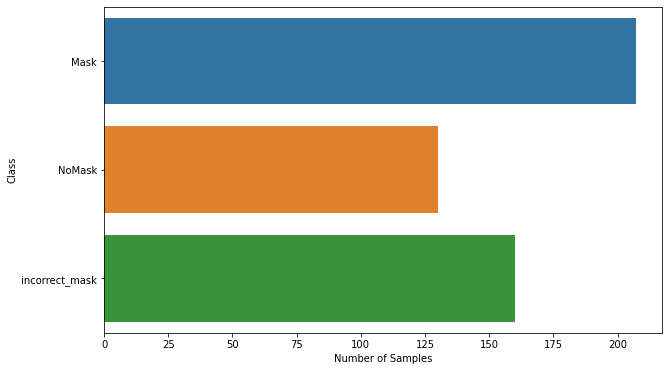

Size of target:  497
Size of original repository:  (497, 10000)
Example of the original repository: 
[[  0   0   0 ...   0   0   0]
 [216 217 225 ...  85  90  69]
 [ 68  72  79 ...  62  91  79]
 ...
 [211 242 239 ... 237 226 214]
 [255 255 255 ... 255 255 255]
 [234 234 234 ... 255 255 255]]
Size of binarised data structure:  (497, 10000)
Example of the binarised repository: 
[[  0   0   0 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
Size of HOG features data structure:  (497, 1800)
Example of the HOG repository: 
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.28305274 0.28305274 0.11572807 ... 0.11283058 0.25534838 0.        ]
 [0.10468382 0.06545634 0.04431782 ... 0.14461644 0.06643612 0.        ]
 ...
 [0.72083379 0.22596698 0.07831653 ... 0.53557562 0.45891267 0.32693783]
 [0.         0.         0.         ... 0.03099142 

In [42]:
# Ignore warnings
import warnings; warnings.simplefilter('ignore')
################################ 1. DEFINE CLASS TO EXTRACT HOG FEATURES ################################    
class HOG:
    def __init__(self, orientations = 9, pixelsPerCell = (8, 8),
        cellsPerBlock = (3, 3), transform = False):
        # store the number of orientations, pixels per cell,
        # cells per block, and whether or not power law
        # compression should be applied
        self.orienations = orientations
        self.pixelsPerCell = pixelsPerCell
        self.cellsPerBlock = cellsPerBlock
        self.transform = transform

    def describe(self, image):
        # compute HOG for the image
        hist = feature.hog(image, orientations = self.orienations,
            pixels_per_cell = self.pixelsPerCell,
            cells_per_block = self.cellsPerBlock,
            transform_sqrt = self.transform)
        ## return the HOG features
        return hist
    
hog = HOG(orientations = 18, pixelsPerCell = (10, 10), cellsPerBlock = (1, 1), transform = True)

########  2. LOAD IMAGES (FOR ORIGINAL REPO), BINARISE (FOR PREPROCESSED REPO) & EXTRACT HOG FEATURES (FOR FEATURE REPO) ######## 

bin_thresh = 180 # Threshold for binarisation
resize_factor = 100 # applies for both height and width

path = 'data'
datarepo = [] # List to append the images as 2D numpy arrays
originalrepo = [] # Create a repo for flattened pixels
binarisedrepo = []  # Create a list to append the binarised pixels
hogrepo = [] # Create a list to append the HOG features
target = [] # List to append the target/class/label
print('\nLoading images...')
for root, dirs, files in os.walk(path):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            try:
                img = cv2.imread(root+'/'+file, 0)
                img = cv2.resize(img, (resize_factor, resize_factor)) 
                datarepo.append(img)
                originalrepo.append(img.flatten())
                _, img_bin = cv2.threshold(img, bin_thresh, 255, 0) 
                # Append the flattened image to the pixel repo
                binarisedrepo.append(img_bin.flatten())
                # Extract HOG and append to HOG repo
                hogfeatures = hog.describe(img)
                hogrepo.append(hogfeatures)
                # Append the folder where the image is to the target list
                target.append(root.replace(path,'').replace('\\',''))
            except Exception as e:
                print("Invalid file "+file+" skipped.")
            
# Convert the repo lists into numpy arrays
originalrepo = np.array(originalrepo)
binarisedrepo = np.array(binarisedrepo)
hogrepo = np.array(hogrepo)

########################## 3. CALCULATE THE DISTRIBUTION AND SHOW REPOS ##########################

print('\nCalculating class distribution...')
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target)))):
    cont = 0
    for j, label2 in enumerate(target):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target)])
## Save the histogram as a .csv file   
with open('classdistribution.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)
## Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total images: '+str(len(target)))
## Create a histogram using seaborn
sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo_panda)
## Save the image
sns_plot.figure.set_size_inches(10,6)
sns_plot.figure.savefig('barchart.jpg', orientation = 'landscape', dpi = 600, transparent=True)
print('\nShowing class distribution bar chart...')
plt.show()
print('Size of target: ', len(target))
print('Size of original repository: ', originalrepo.shape)
print('Example of the original repository: ')
print(originalrepo)
print('Size of binarised data structure: ', binarisedrepo.shape)
print('Example of the binarised repository: ')
print(binarisedrepo)
print('Size of HOG features data structure: ', hogrepo.shape)
print('Example of the HOG repository: ')
print(hogrepo)

################################ 4. SAVE THE DATASETS AS CSV FILES ################################

print('\nSaving datasets as .csv files...')   

with open('original.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, pix in enumerate(originalrepo):
        row = np.concatenate((pix,[target[i]]))
        filewriter.writerow(row)

with open('hog.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, h in enumerate(hogrepo):
        row = np.concatenate((h,[target[i]]))
        filewriter.writerow(row)

with open('binarised.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, l in enumerate(binarisedrepo):
        row = np.concatenate((l,[target[i]]))
        filewriter.writerow(row)

print('\nData saved into .csv files!')

In the next cell, I implemented Random OverSampling (ROS, more info about this algorithm [here](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html)) to perform augmentation of the HOG dataset to balance the classes to 207 each. This new dataset has 621 samples in total.

In [43]:
pip install delayed


Calculating class distribution (after ROS)...
            Class  Number of Samples
0            Mask                207
1          NoMask                207
2  incorrect_mask                207
Total images: 621

Showing class distribution bar chart (after ros)...


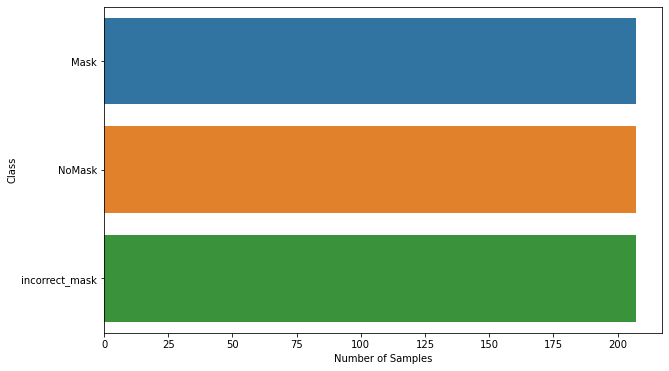

Size of ROS augmented target:  621
Size of ROS augmented repository:  (621, 1800)
Example of the ROS augmented repository: 
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.28305274 0.28305274 0.11572807 ... 0.11283058 0.25534838 0.        ]
 [0.10468382 0.06545634 0.04431782 ... 0.14461644 0.06643612 0.        ]
 ...
 [0.56333942 0.30106717 0.         ... 0.04972036 0.11880215 0.37895655]
 [0.00285298 0.         0.         ... 0.04473263 0.0029757  0.01314691]
 [0.36829587 0.36829587 0.27288409 ... 0.04000181 0.37814945 0.39026114]]

Saving dataset as .csv file...

Data saved!


In [44]:
########################## 1. CALCULATE NEW DATASET USING RANDOM OVERSAMPLING (ROS) ##########################
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
hogrepo_ros, target_ros = ros.fit_resample(hogrepo,target)

################################ 2. CALCULATE THE DISTRIBUTION AFTER ROS ################################

print('\nCalculating class distribution (after ROS)...')
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target_ros)))):
    cont = 0
    for j, label2 in enumerate(target_ros):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target_ros)])
## Save the histogram as a .csv file   
with open('classdistribution_ros.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)
## Convert histo into a panda dataframe
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total images: '+str(len(target_ros)))
## Create a histogram using seaborn
sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo_panda)
## Save the image
sns_plot.figure.set_size_inches(10,6)
sns_plot.figure.savefig('barchart_ros.jpg', orientation = 'landscape', dpi = 600, transparent=True)
print('\nShowing class distribution bar chart (after ros)...')
plt.show()

print('Size of ROS augmented target: ', len(target_ros))
print('Size of ROS augmented repository: ', hogrepo_ros.shape)
print('Example of the ROS augmented repository: ')
print(hogrepo_ros)

################################ 3. SAVE THE ROS DATASET AS CSV FILE ################################

print('\nSaving dataset as .csv file...')   

with open('hog_ros.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, h in enumerate(hogrepo_ros):
        row = np.concatenate((h,[target_ros[i]]))
        filewriter.writerow(row)
        
print('\nData saved!')

Finally, the following cell, i performed the class decomposition with kmeans to create a pixel repository with the decomposed classes. The size of the final repository remains at 497 samples but now it has 4 classes in total.


Calculating k values...
Values of k for each class:  [2, 1, 1]
Number of classes after class decomposition:  4

Class decomposition by applying k-means...
Number of clusters for class Mask: 2
Number of clusters for class NoMask: 1
Number of clusters for class incorrect_mask: 1

Calculating class distribution (after class decomposition)...
               Class  Number of Samples
0            Mask_c0                101
1            Mask_c1                106
2          NoMask_c0                130
3  incorrect_mask_c0                160
Total images: 497

Showing class distribution bar chart (after cd)...


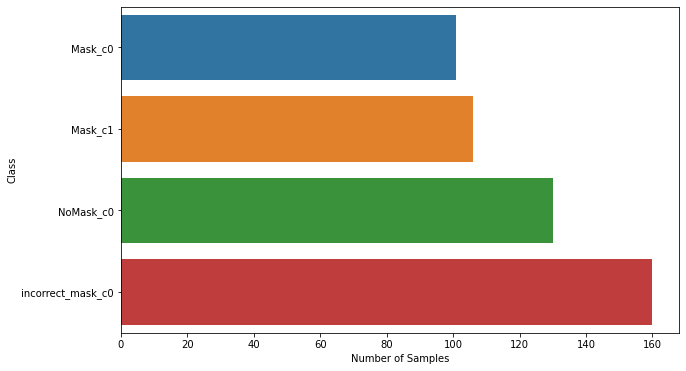


Saving dataset as .csv file...

Data saved!


In [45]:
################################ 1. CALCULATE K USING STANDARD BALANCING EQ ################################

def standardbalancingequation(target):
    '''This function follows the standard balancing equation to calculate k for each class'''
    import math
    print('\nCalculating k values...')
    ## Obtain the number of classes in label list and sort
    labelsIndexesUnique = list(set(target))
    labelsIndexesUnique.sort()
    ## For each class, count the number of instances and calculate ki
    k = []
    for label in labelsIndexesUnique:
        k.append(target.count(label))
    avgInst = sum(k)/len(k)
    k = [math.floor((ki/avgInst)+1) for ki in k]
    print('Values of k for each class: ', k)
    return k

k_kmeans = standardbalancingequation(target)
print('Number of classes after class decomposition: ', sum(k_kmeans))

################################ 2. CLASS DECOMPOSITION USING KMEANS ################################

def CDKmeans(data, target, k):
    print('\nClass decomposition by applying k-means...')    
    from sklearn.cluster import KMeans
    target_cd = ['']*len(target)
    IndexesUnique = list(set(target))
    IndexesUnique.sort()
    for i, label in enumerate(IndexesUnique):
        print('Number of clusters for class '+str(label)+': '+str(k[i]))
        ## Split the dataset
        data_tocluster = []
        data_tocluster_index = []
        for j, dat in enumerate(data):
            if target[j]==label:
                data_tocluster.append(dat)
                data_tocluster_index.append(j)
        if 1<k[i]<=len(data_tocluster):
                ## Apply k-means to the list    
                kmeans = KMeans(n_clusters=k[i], random_state=0).fit(data_tocluster)
                for n, m in enumerate(kmeans.labels_):
                    target_cd[data_tocluster_index[n]]=str(label)+'_c'+str(m)
        else:
            for m in data_tocluster_index:
                target_cd[m]=str(label)+'_c0'
    return target_cd

target_cd = CDKmeans(originalrepo, target, k_kmeans)

################################ 3. CALCULATE THE DISTRIBUTION AFTER CD ################################

print('\nCalculating class distribution (after class decomposition)...')
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target_cd)))):
    cont = 0
    for j, label2 in enumerate(target_cd):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target_cd)])
## Save the histogram as a .csv file   
with open('classdistribution_cd.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)
## Convert histo into a panda dataframe
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total images: '+str(len(target_cd)))
## Create a histogram using seaborn
sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo_panda)
## Save the image
sns_plot.figure.set_size_inches(10,6)
sns_plot.figure.savefig('barchart_cd.jpg', orientation = 'landscape', dpi = 600, transparent=True)
print('\nShowing class distribution bar chart (after cd)...')
plt.show()

################################ 4. SAVE THE CD DATASET AS CSV FILE ################################

print('\nSaving dataset as .csv file...')   

with open('original_cd.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, pix in enumerate(originalrepo):
        row = np.concatenate((pix,[target_cd[i]]))
        filewriter.writerow(row)
        
print('\nData saved!')

## Applying Classification Algorithms and Implementing Validation Frameworks

The train-test slit function was imported from the sklearn model selection

In [46]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

A simple split into training and testing sets was applied in order to compare the performance between the generated datasets and the different classification algorithms.

Accuracy score:  0.77
[[36  6  4]
 [ 2 24  1]
 [ 5  5 17]]
                precision    recall  f1-score   support

          Mask       0.84      0.78      0.81        46
        NoMask       0.69      0.89      0.77        27
incorrect_mask       0.77      0.63      0.69        27

      accuracy                           0.77       100
     macro avg       0.77      0.77      0.76       100
  weighted avg       0.78      0.77      0.77       100



Text(69.0, 0.5, 'Truth')

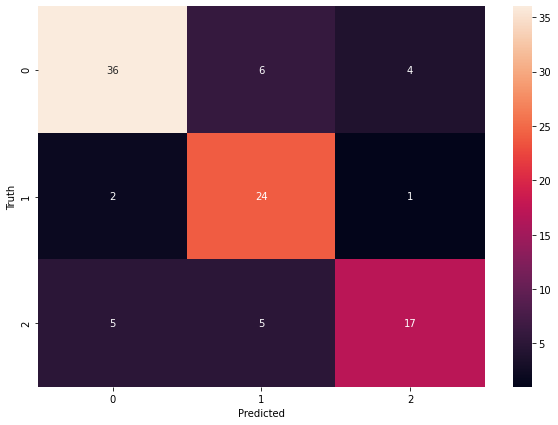

In [47]:
#### I started by converting each dataset to a dataframe before splitting the respective dataframes into training and testing sets. Here i started with the priginal repository
################################ 1. CONVERTING THE ORIGINAL REPO DATASET INTO A DATAFRAME ################################

original_df = pd.read_csv('original.csv')
original_df

################################ 2. PREPROCESSING ################################
X = original_df.drop('incorrect_mask', axis=1)
y = original_df['incorrect_mask']
################################ 3. SPLITTING THE DATASET FOR ORIGINAL REPO ################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) # 80% training and 20% test

################################ 4. TRAINING THE ALGORITHM ################################
# I then trained the algorithm using the SVC linear kernel and used a very large C parameter because i'm betting that the training data contains  the most extreme possible observations
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C = 1E10)
svclassifier.fit(X_train, y_train)

################################ 5. MAKING PREDICTIONS ################################
# After training my algorithms i made predictions on the test data
y_pred = svclassifier.predict(X_test)

################################ 6. MAKING EVALUATIONS ################################
# I then made evaluations for the linear model
from sklearn.metrics import accuracy_score
print ('Accuracy score: ', accuracy_score(y_test, y_pred))
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm
################################ 7. PLOTTING CONFUSION MATRIX ################################
plt.figure(figsize =(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

It can be noticed from the 'recall' that the amount of observed cases that were correctly predicted as positive were 78% for Mask, 89% for NoMask and 63% for incorrect_mask. These are good score but not too great. From the 'precision' it can be observed that of the predicted cases, 77% were correct for incorrect_mask, 69% were correct for the NoMask while 84% were correct for Mask. The f1-score was 81% for Mask, 77% for NoMask and 69% for incorrect_mask. Also an accuracy score of 77%. These scores are just above average and doesn't signify the svm performed optimally on the original repo

Accuracy score:  0.65
[[33  7  6]
 [ 5 18  4]
 [ 7  6 14]]
                precision    recall  f1-score   support

          Mask       0.73      0.72      0.73        46
        NoMask       0.58      0.67      0.62        27
incorrect_mask       0.58      0.52      0.55        27

      accuracy                           0.65       100
     macro avg       0.63      0.63      0.63       100
  weighted avg       0.65      0.65      0.65       100



Text(69.0, 0.5, 'Truth')

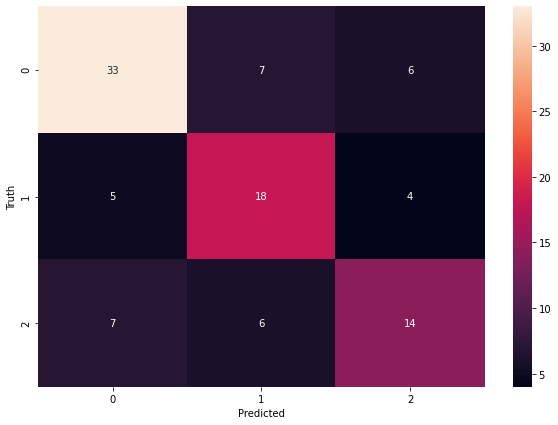

In [48]:
#### I also coverted the binarised dataset to a dataframe before splitting the dataframe into training and testing sets
################################ 1. CONVERTING THE CLASS DECOMPOSED REPO DATASET INTO A DATAFRAME ################################

binarised_df = pd.read_csv('binarised.csv')
binarised_df

################################ 2. PREPROCESSING ################################
X = binarised_df.drop('incorrect_mask', axis=1)
y = binarised_df['incorrect_mask']
################################ 3. SPLITTING THE DATASET FOR CLASS DECOMPOSED REPO ################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) # 80% training and 20% test

################################ 4. TRAINING THE ALGORITHM ################################
# I then trained the algorithm using the SVC linear kernel and used a very large C parameter because i'm betting that the training data contains  the most extreme possible observations
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C = 1E10)
svclassifier.fit(X_train, y_train)

################################ 5. MAKING PREDICTIONS ################################
# After training my algorithms i made predictions on the test data
y_pred = svclassifier.predict(X_test)

################################ 6. MAKING EVALUATIONS ################################
# I then made evaluations for the linear model
from sklearn.metrics import accuracy_score
print ('Accuracy score: ', accuracy_score(y_test, y_pred))
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm
################################ 7. PLOTTING CONFUSION MATRIX ################################
plt.figure(figsize =(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

It can be noticed from the 'recall' that the amount of observed cases that were correctly predicted as positive were 72% for Mask, 67% for NoMask and 52% for incorrect_mask. These are good score but not too great. From the 'precision' it can be observed that of the predicted cases, 58% were correct for incorrect_mask, 58% were correct for the NoMask while 73% were correct for Mask. The f1-score was 73% for Mask, 62% for NoMask and 55% for incorrect_mask. Also an accuracy score of 65%. Overall the svc performed poorly on the binarised dataset compared to the original

Accuracy score:  0.73
[[16  0  4  5]
 [ 1 19  1  0]
 [ 2  3 21  1]
 [ 2  4  4 17]]
                   precision    recall  f1-score   support

          Mask_c0       0.76      0.64      0.70        25
          Mask_c1       0.73      0.90      0.81        21
        NoMask_c0       0.70      0.78      0.74        27
incorrect_mask_c0       0.74      0.63      0.68        27

         accuracy                           0.73       100
        macro avg       0.73      0.74      0.73       100
     weighted avg       0.73      0.73      0.73       100



Text(69.0, 0.5, 'Truth')

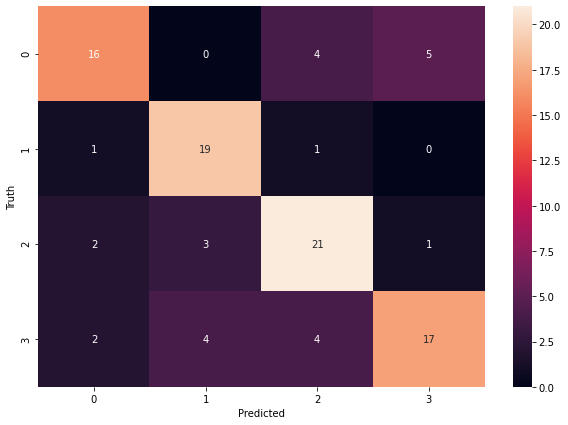

In [49]:
#### I also coverted the class decomposed dataset to a dataframe before splitting the dataframe into training and testing sets
################################ 1. CONVERTING THE CLASS DECOMPOSED REPO DATASET INTO A DATAFRAME ################################

originalcd_df = pd.read_csv('original_cd.csv')
original_df

################################ 2. PREPROCESSING ################################
X = originalcd_df.drop('incorrect_mask_c0', axis=1)
y = originalcd_df['incorrect_mask_c0']
################################ 3. SPLITTING THE DATASET FOR CLASS DECOMPOSED REPO ################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) # 80% training and 20% test

################################ 4. TRAINING THE ALGORITHM ################################
# I then trained the algorithm using the SVC linear kernel and used a very large C parameter because i'm betting that the training data contains  the most extreme possible observations
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C = 1E10)
svclassifier.fit(X_train, y_train)

################################ 5. MAKING PREDICTIONS ################################
# After training my algorithms i made predictions on the test data
y_pred = svclassifier.predict(X_test)

################################ 6. MAKING EVALUATIONS ################################
# I then made evaluations for the linear model
from sklearn.metrics import accuracy_score
print ('Accuracy score: ', accuracy_score(y_test, y_pred))
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm
################################ 7. PLOTTING CONFUSION MATRIX ################################
plt.figure(figsize =(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

It can be noticed from the 'recall' that the amount of observed cases that were correctly predicted as positive were 64% for Mask, 78% for NoMask and 63% for incorrect_mask. These are good score but not too great. From the 'precision' it can be observed that of the predicted cases, 74% were correct for incorrect_mask, 70% were correct for the NoMask while 76% were correct for Mask_c0 & 73% correct for Mask_c1.  The f1-score was 70% for Mask_c0, 81% for Mask_c1, 74% for NoMask and 68% for incorrect_mask. Also an accuracy score of 73%. These scores show that the svm performed poorer with the class decomposed dataset compared to the original dataset

Accuracy score:  0.79
[[33  8  5]
 [ 6 21  0]
 [ 1  1 25]]
                precision    recall  f1-score   support

          Mask       0.82      0.72      0.77        46
        NoMask       0.70      0.78      0.74        27
incorrect_mask       0.83      0.93      0.88        27

      accuracy                           0.79       100
     macro avg       0.79      0.81      0.79       100
  weighted avg       0.79      0.79      0.79       100



Text(69.0, 0.5, 'Truth')

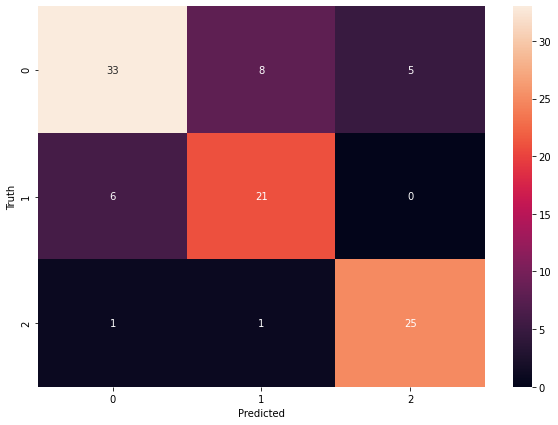

In [50]:
#### I also coverted the HOG dataset to a dataframe before splitting the dataframe into training and testing sets
################################ 1. CONVERTING THE HOG REPO DATASET INTO A DATAFRAME ################################

hog_df = pd.read_csv('hog.csv')
hog_df

################################ 2. PREPROCESSING ################################
X = hog_df.drop('incorrect_mask', axis=1)
y = hog_df['incorrect_mask']
################################ 3. SPLITTING THE DATASET FOR HOG REPO ################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) # 80% training and 20% test

################################ 4. TRAINING THE ALGORITHM ################################
# I then trained the algorithm using the SVC linear kernel and used a very large C parameter because i'm betting that the training data contains  the most extreme possible observations
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C = 1E10)
svclassifier.fit(X_train, y_train)

################################ 5. MAKING PREDICTIONS ################################
# After training my algorithms i made predictions on the test data
y_pred = svclassifier.predict(X_test)

################################ 6. MAKING EVALUATIONS ################################
# I then made evaluations for the linear model
from sklearn.metrics import accuracy_score
print ('Accuracy score: ', accuracy_score(y_test, y_pred))
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm
################################ 7. PLOTTING CONFUSION MATRIX ################################
plt.figure(figsize =(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

It can be noticed from the 'recall' that the amount of observed cases that were correctly predicted as positive were 72% for Mask, 78% for NoMask and 93% for incorrect_mask. From the 'precision' it can be observed that of the predicted cases, 83% were correct for incorrect_mask, 70% were correct for the NoMask while 82% were correct for Mask.  The f1-score was 77% for Mask, 74% for NoMask and 88% for incorrect_mask. Also an accuracy score of 79%. These shows the svm performed poorly for the HOG compared to the original and class decomposed repo for correctly identify mask and no_mask but performed better for the incorrect_mask

Accuracy score:  0.8709677419354839
[[33  5  1]
 [ 3 42  0]
 [ 4  3 33]]
                precision    recall  f1-score   support

          Mask       0.82      0.85      0.84        39
        NoMask       0.84      0.93      0.88        45
incorrect_mask       0.97      0.82      0.89        40

      accuracy                           0.87       124
     macro avg       0.88      0.87      0.87       124
  weighted avg       0.88      0.87      0.87       124



Text(69.0, 0.5, 'Truth')

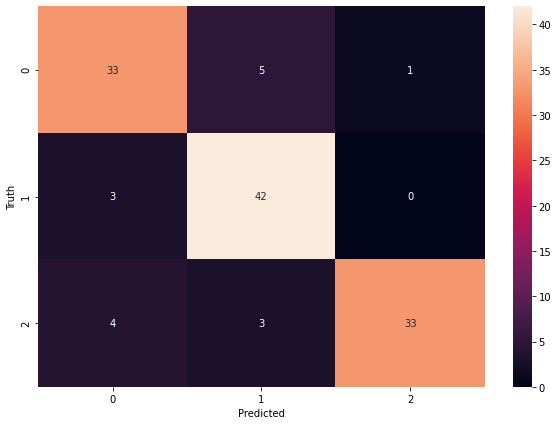

In [12]:
#### I also coverted the HOG_ros dataset to a dataframe before splitting the dataframe into training and testing sets
################################ 1. CONVERTING THE HOG_ros REPO DATASET INTO A DATAFRAME ################################

hogros_df = pd.read_csv('hog_ros.csv')
hogros_df

################################ 2. PREPROCESSING ################################
X = hogros_df.drop('incorrect_mask', axis=1)
y = hogros_df['incorrect_mask']
################################ 3. SPLITTING THE DATASET FOR HOG_ros REPO ################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) # 80% training and 20% test

################################ 4. TRAINING THE ALGORITHM ################################
# I then trained the algorithm using the SVC linear kernel and used a very large C parameter because i'm betting that the training data contains  the most extreme possible observations
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C = 1E10)
svclassifier.fit(X_train, y_train)

################################ 5. MAKING PREDICTIONS ################################
# After training my algorithms i made predictions on the test data
y_pred = svclassifier.predict(X_test)

################################ 6. MAKING EVALUATIONS ################################
# I then made evaluations for the linear model
from sklearn.metrics import accuracy_score
print ('Accuracy score: ', accuracy_score(y_test, y_pred))
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm
################################ 7. PLOTTING CONFUSION MATRIX ################################
plt.figure(figsize =(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

It can be noticed from the 'recall' that the amount of observed cases that were correctly predicted as positive were 85% for Mask, 93% for NoMask and 82% for incorrect_mask. From the 'precision' it can be observed that of the predicted cases, 97% were correct for incorrect_mask, 84% were correct for the NoMask while 82% were correct for Mask. The f1-score was 84% for Mask, 88% for NoMask and 89% for incorrect_mask. Also an accuracy score of 87%. These shows the svm performed better for the HOG_ros compared to the HOG repo

### I then decided to check the performance of the random forest in correctly classifying data on the different generated datasets

Accuracy: 0.8
                precision    recall  f1-score   support

          Mask       0.77      0.89      0.83        46
        NoMask       0.90      0.70      0.79        27
incorrect_mask       0.77      0.74      0.75        27

      accuracy                           0.80       100
     macro avg       0.82      0.78      0.79       100
  weighted avg       0.81      0.80      0.80       100



Text(69.0, 0.5, 'Truth')

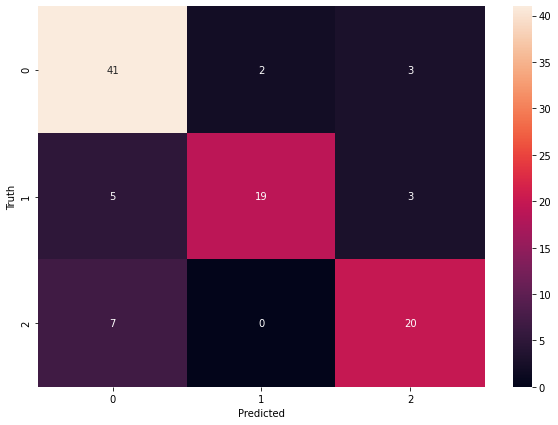

In [51]:
#### I started by splitting the original dataframe into training and testing sets
################################ 1. CREATING DATAFRAME ################################
# importing the necessary package and creating dataframe
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
original_df = pd.read_csv('original.csv')
original_df
################################ 2. PREPROCESSING ################################
X = original_df.drop('incorrect_mask', axis=1)
y = original_df['incorrect_mask']
################################ 3. SPLITTING THE DATASET FOR HOG_ros REPO ################################
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) # 80% training and 20% test

################################ 4. GAUSSIAN CLASSIFIER ################################
# I created a Gaussian classifier
clf=RandomForestClassifier(n_estimators=100)
################################ 5. TRAINING THE ALGORITHM ################################
# I then trained the algorithm using the random forest
clf.fit(X_train,y_train)
clf.score(X_test, y_test)

################################ 6. MAKING PREDICTIONS ################################
# After training my algorithms i made predictions on the test data
y_pred=clf.predict(X_test)

################################ 7. MAKING EVALUATIONS ################################
# I then made evaluations for the random forest
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm
################################ 8. PLOTTING CONFUSION MATRIX ################################
plt.figure(figsize =(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

The random forest with hundred trees trained with the original repo dataframe produced and accuracy of 81%

Accuracy: 0.72
                precision    recall  f1-score   support

          Mask       0.78      0.76      0.77        46
        NoMask       0.76      0.59      0.67        27
incorrect_mask       0.62      0.78      0.69        27

      accuracy                           0.72       100
     macro avg       0.72      0.71      0.71       100
  weighted avg       0.73      0.72      0.72       100



Text(69.0, 0.5, 'Truth')

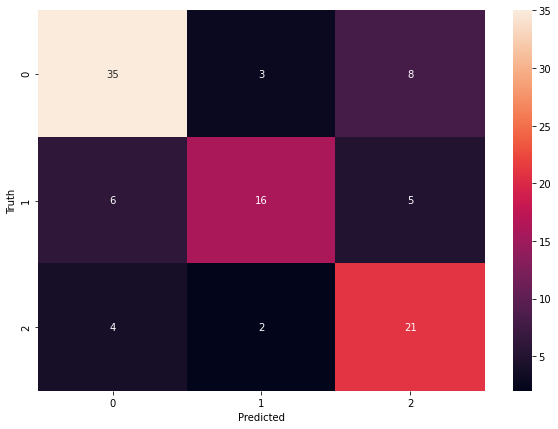

In [52]:
#### I split the binarised dataframe into training and testing sets
################################ 1. CREATING DATAFRAME ################################
# importing the necessary package and creating dataframe
from sklearn import metrics
binarised_df = pd.read_csv('binarised.csv')
binarised_df
################################ 2. PREPROCESSING ################################
X = binarised_df.drop('incorrect_mask', axis=1)
y = binarised_df['incorrect_mask']
################################ 3. SPLITTING THE DATASET FOR HOG_ros REPO ################################
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) # 80% training and 20% test

################################ 4. GAUSSIAN CLASSIFIER ################################
# I created a Gaussian classifier
clf=RandomForestClassifier(n_estimators=100)
################################ 5. TRAINING THE ALGORITHM ################################
# I then trained the algorithm using the random forest
clf.fit(X_train,y_train)
clf.score(X_test, y_test)

################################ 6. MAKING PREDICTIONS ################################
# After training my algorithms i made predictions on the test data
y_pred=clf.predict(X_test)

################################ 7. MAKING EVALUATIONS ################################
# I then made evaluations for the random forest
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm
################################ 8. PLOTTING CONFUSION MATRIX ################################
plt.figure(figsize =(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

The random forest with hundred trees trained with the binarised repo dataframe produced and accuracy of 75%

Accuracy: 0.77
                   precision    recall  f1-score   support

          Mask_c0       0.77      0.68      0.72        25
          Mask_c1       0.87      0.95      0.91        21
        NoMask_c0       0.86      0.70      0.78        27
incorrect_mask_c0       0.64      0.78      0.70        27

         accuracy                           0.77       100
        macro avg       0.79      0.78      0.78       100
     weighted avg       0.78      0.77      0.77       100



Text(69.0, 0.5, 'Truth')

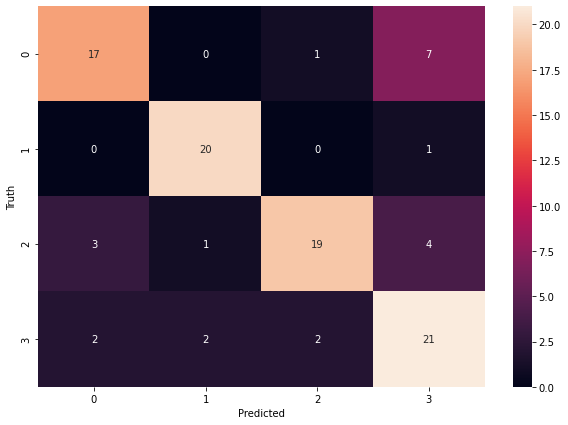

In [53]:
#### I split the class decomposed dataframe into training and testing sets
################################ 1. CREATING DATAFRAME ################################
# importing the necessary package and creating dataframe
from sklearn import metrics
originalcd_df = pd.read_csv('original_cd.csv')
originalcd_df
################################ 2. PREPROCESSING ################################
X = originalcd_df.drop('incorrect_mask_c0', axis=1)
y = originalcd_df['incorrect_mask_c0']
################################ 3. SPLITTING THE DATASET FOR HOG_ros REPO ################################
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) # 80% training and 20% test

################################ 4. GAUSSIAN CLASSIFIER ################################
# I created a Gaussian classifier
clf=RandomForestClassifier(n_estimators=100)
################################ 5. TRAINING THE ALGORITHM ################################
# I then trained the algorithm using the random forest
clf.fit(X_train,y_train)
clf.score(X_test, y_test)

################################ 6. MAKING PREDICTIONS ################################
# After training my algorithms i made predictions on the test data
y_pred=clf.predict(X_test)

################################ 7. MAKING EVALUATIONS ################################
# I then made evaluations for the random forest
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm
################################ 8. PLOTTING CONFUSION MATRIX ################################
plt.figure(figsize =(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

The random forest with hundred trees trained with the class decomposed repo dataframe produced and accuracy of 83%

Accuracy: 0.76
                precision    recall  f1-score   support

          Mask       0.70      0.87      0.78        46
        NoMask       0.84      0.59      0.70        27
incorrect_mask       0.83      0.74      0.78        27

      accuracy                           0.76       100
     macro avg       0.79      0.73      0.75       100
  weighted avg       0.78      0.76      0.76       100



Text(69.0, 0.5, 'Truth')

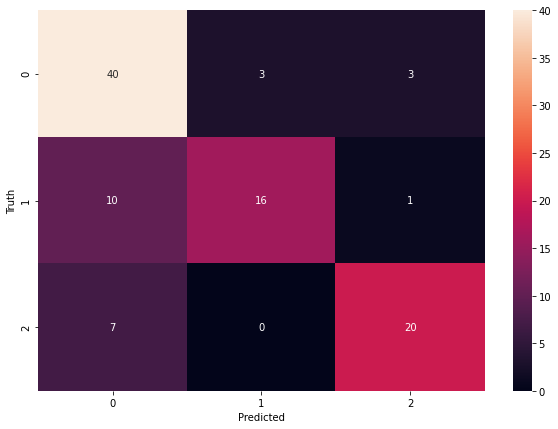

In [54]:
#### I split the HOG dataframe into training and testing sets
################################ 1. CREATING DATAFRAME ################################
# importing the necessary package and creating dataframe
from sklearn import metrics
hog_df = pd.read_csv('hog.csv')
original_df
################################ 2. PREPROCESSING ################################
X = hog_df.drop('incorrect_mask', axis=1)
y = hog_df['incorrect_mask']
################################ 3. SPLITTING THE DATASET FOR HOG_ros REPO ################################
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) # 80% training and 20% test

################################ 4. GAUSSIAN CLASSIFIER ################################
# I created a Gaussian classifier
clf=RandomForestClassifier(n_estimators=100)
################################ 5. TRAINING THE ALGORITHM ################################
# I then trained the algorithm using the random forest
clf.fit(X_train,y_train)
clf.score(X_test, y_test)

################################ 6. MAKING PREDICTIONS ################################
# After training my algorithms i made predictions on the test data
y_pred=clf.predict(X_test)

################################ 7. MAKING EVALUATIONS ################################
# I then made evaluations for the tandom forest
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm
################################ 8. PLOTTING CONFUSION MATRIX ################################
plt.figure(figsize =(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

The random forest with hundred trees trained with the HOG repo dataframe produced and accuracy of 77%

Accuracy: 0.8145161290322581
                precision    recall  f1-score   support

          Mask       0.74      0.74      0.74        39
        NoMask       0.85      0.87      0.86        45
incorrect_mask       0.85      0.82      0.84        40

      accuracy                           0.81       124
     macro avg       0.81      0.81      0.81       124
  weighted avg       0.81      0.81      0.81       124



Text(69.0, 0.5, 'Truth')

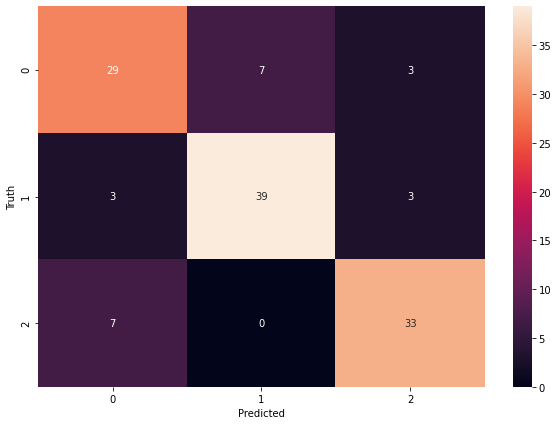

In [55]:
#### I split the HOG_ros dataframe into training and testing sets
################################ 1. CREATING DATAFRAME ################################
# importing the necessary package and creating dataframe
from sklearn import metrics
hogros_df = pd.read_csv('hog_ros.csv')
hogros_df
################################ 2. PREPROCESSING ################################
X = hogros_df.drop('incorrect_mask', axis=1)
y = hogros_df['incorrect_mask']
################################ 3. SPLITTING THE DATASET FOR HOG_ros REPO ################################
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) # 80% training and 20% test

################################ 4. GAUSSIAN CLASSIFIER ################################
# I created a Gaussian classifier
clf=RandomForestClassifier(n_estimators=100)
################################ 5. TRAINING THE ALGORITHM ################################
# I then trained the algorithm using the random forest
clf.fit(X_train,y_train)
clf.score(X_test, y_test)

################################ 6. MAKING PREDICTIONS ################################
# After training my algorithms i made predictions on the test data
y_pred=clf.predict(X_test)

################################ 7. MAKING EVALUATIONS ################################
# I then made evaluations for the random forest
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm
################################ 8. PLOTTING CONFUSION MATRIX ################################
plt.figure(figsize =(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

The random forest with hundred trees trained with the HOG repo dataframe produced and accuracy of 80%

###### From the foregoing it is clear that the SVC had its highest accuracy when applied to the hog_ros with 87%, while its lowest performance was with the binarised dataset with 65%. Meanwhile the Random Forest had its highest accuracy when applied to the original dataset with 81% while with the binarised dataset it had its least accuracy of 75%.

## Using Crossvalidation to compare the RF & SVC

In [56]:
# i decided to crossvalidate between the random forest and the svc across the originalrepo, binarisedrepo and hogrepo
# starting with the originalrepo
# importing the crossvalidate package
from sklearn.model_selection import cross_validate
################################ 1. CROSSVALIDATING ON THE ORIGINAL DATASET ################################
scores_svm = cross_validate(svclassifier, originalrepo, target, cv=5)
print('SVM cross-validated scores: ', scores_svm)
scores_rf = cross_validate(clf, originalrepo, target, cv=5)
print('RF cross-validated scores: ', scores_rf)

SVM cross-validated scores:  {'fit_time': array([0.86212254, 0.81224132, 0.75911903, 0.78290606, 0.83408642]), 'score_time': array([0.11768436, 0.12521839, 0.12182283, 0.119416  , 0.12109828]), 'test_score': array([0.7       , 0.71      , 0.78787879, 0.6969697 , 0.70707071])}
RF cross-validated scores:  {'fit_time': array([1.16531801, 1.09708714, 1.11335492, 1.41383839, 1.56083393]), 'score_time': array([0.00997329, 0.00998783, 0.00999284, 0.01491737, 0.01756287]), 'test_score': array([0.76      , 0.76      , 0.80808081, 0.82828283, 0.67676768])}


Crossvalidating the RF and SVC showed that for the original repo, the RF took longer to fit

In [57]:
# i decided to crossvalidate between the random forest and the SVC on the binarised repo
# importing the crossvalidate package
from sklearn.model_selection import cross_validate
################################ 1. CROSSVALIDATING ON THE ORIGINAL DATASET ################################
scores_svm = cross_validate(svclassifier, binarisedrepo, target, cv=5)
print('SVM cross-validated scores: ', scores_svm)
scores_rf = cross_validate(clf, binarisedrepo, target, cv=5)
print('RF cross-validated scores: ', scores_rf)

SVM cross-validated scores:  {'fit_time': array([0.84875846, 0.83624196, 0.83420157, 0.83015966, 0.82299328]), 'score_time': array([0.148072  , 0.14909887, 0.15273428, 0.14393854, 0.14416456]), 'test_score': array([0.63      , 0.73      , 0.70707071, 0.60606061, 0.56565657])}
RF cross-validated scores:  {'fit_time': array([0.50418496, 0.46675014, 0.47789621, 0.48388457, 0.47645497]), 'score_time': array([0.01296592, 0.01293683, 0.01296878, 0.01198745, 0.0129652 ]), 'test_score': array([0.74      , 0.71      , 0.71717172, 0.73737374, 0.70707071])}


For the binarisedrepo, the SVC took a longer time to fit than the RF

In [58]:
# i decided to crossvalidate between the random forest and the SVC on the hogrepo
# importing the crossvalidate package
from sklearn.model_selection import cross_validate
################################ 1. CROSSVALIDATING ON THE ORIGINAL DATASET ################################
scores_svm = cross_validate(svclassifier, hogrepo, target, cv=5)
print('SVM cross-validated scores: ', scores_svm)
scores_rf = cross_validate(clf, hogrepo, target, cv=5)
print('RF cross-validated scores: ', scores_rf)

SVM cross-validated scores:  {'fit_time': array([0.12881875, 0.06781745, 0.06485772, 0.06192636, 0.07414603]), 'score_time': array([0.0118053 , 0.01099586, 0.01096535, 0.01095963, 0.03104782]), 'test_score': array([0.8       , 0.81      , 0.74747475, 0.81818182, 0.74747475])}
RF cross-validated scores:  {'fit_time': array([0.48460984, 0.49026799, 0.47654104, 0.50384212, 0.48869896]), 'score_time': array([0.00897264, 0.0090282 , 0.0089612 , 0.00797868, 0.00797892]), 'test_score': array([0.71      , 0.71      , 0.72727273, 0.70707071, 0.66666667])}


For the hogrepo, the SVC also took a longer time to fit than the RF

i then used the cross validation score to:
Evaluate accuracy for each fold,
Evaluate the mean accuracy for all folds,
Evaluating Precision, Recall and F1-score (both by fold and average),

In [59]:
# First i import cross_val_scores
from sklearn.model_selection import cross_val_score

##### Started by finding these values for the originalrepo

In [60]:
# Evaluating Accuracy for each fold
print('Accuracy for SVM: ',cross_val_score(svclassifier, originalrepo, target, cv=5, scoring = 'accuracy'))
print('Accuracy for RF: ',cross_val_score(clf, originalrepo, target, cv=5, scoring = 'accuracy'))

Accuracy for SVM:  [0.7        0.71       0.78787879 0.6969697  0.70707071]
Accuracy for RF:  [0.78       0.75       0.74747475 0.75757576 0.70707071]


In [61]:
# Evaluating Mean Accuracy for all folds
print('Mean Accuracy for SVM: ',np.mean(cross_val_score(svclassifier, originalrepo, target, cv=5, scoring = 'accuracy')))
print('Mean Accuracy for RF: ',np.mean(cross_val_score(clf, originalrepo, target, cv=5, scoring = 'accuracy')))

Mean Accuracy for SVM:  0.7203838383838383
Mean Accuracy for RF:  0.7504444444444445


##### Finding these values for the binarisedrepo

In [62]:
# Evaluating Accuracy for each fold
print('Accuracy for SVM: ',cross_val_score(svclassifier, binarisedrepo, target, cv=5, scoring = 'accuracy'))
print('Accuracy for RF: ',cross_val_score(clf, binarisedrepo, target, cv=5, scoring = 'accuracy'))

Accuracy for SVM:  [0.63       0.73       0.70707071 0.60606061 0.56565657]
Accuracy for RF:  [0.62       0.72       0.78787879 0.77777778 0.6969697 ]


In [63]:
# Evaluating Mean Accuracy for all folds
print('Mean Accuracy for SVM: ',np.mean(cross_val_score(svclassifier, binarisedrepo, target, cv=5, scoring = 'accuracy')))
print('Mean Accuracy for RF: ',np.mean(cross_val_score(clf, binarisedrepo, target, cv=5, scoring = 'accuracy')))

Mean Accuracy for SVM:  0.6477575757575758
Mean Accuracy for RF:  0.7385858585858586


##### Finding these values for the hogrepo

In [64]:
# Evaluating Accuracy for each fold
print('Accuracy for SVM: ',cross_val_score(svclassifier, hogrepo, target, cv=5, scoring = 'accuracy'))
print('Accuracy for RF: ',cross_val_score(clf, hogrepo, target, cv=5, scoring = 'accuracy'))

Accuracy for SVM:  [0.8        0.81       0.74747475 0.81818182 0.74747475]
Accuracy for RF:  [0.66       0.75       0.70707071 0.68686869 0.67676768]


In [65]:
# Evaluating Mean Accuracy for all folds
print('Mean Accuracy for SVM: ',np.mean(cross_val_score(svclassifier, hogrepo, target, cv=5, scoring = 'accuracy')))
print('Mean Accuracy for RF: ',np.mean(cross_val_score(clf, hogrepo, target, cv=5, scoring = 'accuracy')))

Mean Accuracy for SVM:  0.7846262626262627
Mean Accuracy for RF:  0.7002020202020202


### Applying CNN on the 2D images & implementing validation framework

I started by installing the necessary packages needed for the CNN to be trained

In [67]:
# installing the necessary packages
!pip install keras
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=5f368545b06d81f2b6f11c4188c7e338f6fe5ae7f5b3f845712cdf6fc33a29f3
  Stored in directory: c:\users\nsena\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=1b023f7466a89b6bcc96bc2b5797a5a609919696a264a14acdbf9fb7da0ef51f
  Stored in directory: c:\users\nsena\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built termcolor wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2


importing necessary packages

In [220]:
# Import modules
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.utils import np_utils

#### Using Tensorflow backend

Then, we will set a random seed to be able to repeat the results and get the same results every time

In [70]:
#  Set random seed (for reproducibility)
np.random.seed(123)

With the following cell, the data was downloaded from the datarepo dataset:

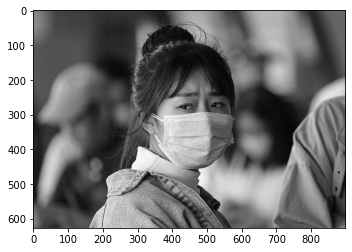

In [221]:
#  Specifying data directory
DATADIR = 'data'
CATEGORIES = ["Mask", "NoMask", "incorrect_mask"]

# iterate through our folder and files
for root, dirs, files in os.walk(path):
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) # path to Mask, NoMask, incorrect_mask dir
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            plt.imshow(img_array, cmap = "gray")
            plt.show()
            break
        break

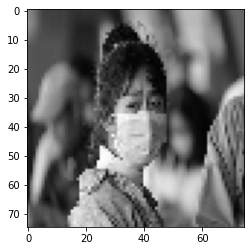

In [222]:
# making all the images of the same shape
IMG_SIZE = 75 # choosing a size


new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # applying the new size to all the images
plt.imshow(new_array, cmap = 'gray')
plt.show() #showing the new resized images

In [299]:
# creating training dataset
training_data = []

def create_training_data():
        for category in CATEGORIES:
            path = os.path.join(DATADIR, category) # path to Mask, NoMask, incorrect_mask dir
            class_num = CATEGORIES.index(category)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    training_data.append([new_array, class_num])
                except EXCEPTION as e:
                    pass
            
create_training_data()
print(len(training_data)) # printing the length of the length of the new trainin data

497


In [154]:
# import package to shuffle through the data
import random
random.shuffle(training_data)

In [155]:
# to check that our labels are correct
for sample in training_data[:10]:
    print(sample[1])

2
0
2
1
0
1
1
0
2
1


In [156]:
# packing it into the variables to be fed into our neural network
X = [] # feature set
y = [] # labels

In [157]:
for features, label in training_data:
    X.append(features)
    y.append(label)

X= np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [158]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out) # dumping X to pickle_out
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out) # dumping y to pickle_out
pickle_out.close()

In [159]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

In [294]:
# importing the neccesary packages and modules
from keras.utils import to_categorical
import tensorflow as tf
from  tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten, Conv2D, MaxPooling2D
import pickle

X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# scaling the data in order to normalize it
def convertOnehot(label):
    y=np.array(label)
    OneHotencoded= to_categorical(y)
    return OneHotencoded
y=convertOnehot(y) 
X = X/255.0

model = Sequential() # this is going to be a sequential model
model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dense(1))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size= (2,2)))

model.add(Flatten())
model.add(Dense(64))


model.add(Dense(3, activation="softmax"))      
model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])
#  Running the fitment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model.fit(X_train, y_train, batch_size = 20, epochs = 3, validation_split= 0.1,)

# Evaluate model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Loss: ', loss,'\nAcc: ', accuracy)
# Check the label that has been predicted
predicted_labels = model.predict(X_test)
#print(predicted_labels)
p=np.argmax(predicted_labels,axis=1)
print(p)

# Check the label that has been predicted incorrectly
incorrect_labels = np.nonzero(p!=np.argmax(y_test,axis=1))
print(incorrect_labels)

Epoch 1/3
16/16 [==============================] - 2s 83ms/step - loss: 1.1010 - accuracy: 0.3801 - val_loss: 1.1745 - val_accuracy: 0.3143
Epoch 2/3
16/16 [==============================] - 1s 79ms/step - loss: 1.0527 - accuracy: 0.3868 - val_loss: 0.9930 - val_accuracy: 0.5429
Epoch 3/3
16/16 [==============================] - 1s 76ms/step - loss: 0.8479 - accuracy: 0.6561 - val_loss: 0.8015 - val_accuracy: 0.6000
Loss:  0.9099863767623901 
Acc:  0.6066666841506958
[0 2 2 2 0 1 0 1 2 2 0 2 0 1 0 2 2 2 0 1 1 1 0 0 2 1 0 0 0 0 1 1 2 1 0 1 1
 2 1 0 2 1 0 2 1 2 1 1 2 0 0 1 2 2 0 0 0 1 2 1 2 1 0 2 1 2 0 1 1 2 0 0 2 1
 0 1 2 1 1 2 0 1 0 0 2 2 1 0 1 2 2 2 0 0 2 0 2 2 2 1 2 2 0 1 2 1 2 0 1 1 0
 1 2 2 2 2 1 2 1 0 1 1 0 2 1 0 2 2 1 1 1 0 2 2 2 2 1 0 1 1 2 2 2 1 1 1 1 2
 1 1]
(array([  2,   6,   7,   9,  10,  15,  19,  20,  21,  24,  28,  30,  31,
        33,  34,  35,  37,  38,  39,  40,  43,  44,  48,  51,  52,  58,
        59,  63,  78,  79,  80,  81,  82,  86,  90,  91,  95,  96,  97,
     

From the foregoing, after training the CNN, 59 images from the test set were incorrectly labeled. After 3 epochs, we had a validation accuracy of 60%

In [301]:
p=np.argmax(predicted_labels)
print(p)

380


In total 380 images were predicted

Ground truth label:  [0. 0. 1.]
Predicted label:  [0.38808262 0.26094916 0.35096812]


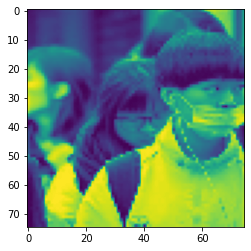

In [302]:
# Here i tried to print out an image that was improperly labeled just to confirm
image_to_show = 6
from_group = 'test' # put 'train' or 'test'
if from_group == 'train':
    plt.imshow(X_train[image_to_show])
    print('Ground truth label: ',y_train[image_to_show])
else:
    plt.imshow(X_test[image_to_show])
    print('Ground truth label: ',y_test[image_to_show])
    if len(predicted_labels)>image_to_show:
        print('Predicted label: ',predicted_labels[image_to_show])

Ground truth label:  [1. 0. 0.]
Predicted label:  [0.5618856  0.10329848 0.33481595]


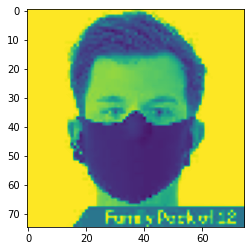

In [303]:
# Here i tried to print out an image that was properly labeled just to confirm
image_to_show = 4
from_group = 'test' # put 'train' or 'test'
if from_group == 'train':
    plt.imshow(X_train[image_to_show])
    print('Ground truth label: ',y_train[image_to_show])
else:
    plt.imshow(X_test[image_to_show])
    print('Ground truth label: ',y_test[image_to_show])
    if len(predicted_labels)>image_to_show:
        print('Predicted label: ',predicted_labels[image_to_show])

from the foregoing rounding up the decimals in the arrays of the predicted labels into whole numbers and comparing with the ground truth one can confirm what was incorrectly labeled.

### Conclusion

Crossvalidating the RF and SVC showed that for the original repo, the RF took longer to fit
For the binarisedrepo, the SVC took a longer time to fit than the RF
For the hogrepo, the SVC also took a longer time to fit than the RF
SVC accuracy on original dataset was 77%
RF accuracy on original dataset was 80%
SVC accuracy on the class decomposed dataset was 65%
RF accuracy on class decomposed dataset was 73%
SVC accuracy on the hog dataset was 79%
RF accuracy on hog dataset was 76%
SVC accuracy on the hog_ros dataset was 87%
RF accuracy on hog_ros dataset was 87%
validation accuracy of the CNN after three epochs is 60 %

## Recomendation

Due to time constraint, i had challenges of visualizing the CNN and comparing with NN, and RNN
I will also need to have more hidden layers of the neural network in order to increase the accuracy of the neural network